In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from copy import deepcopy
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [3]:
from evaluate_metrics import plot_learning_curve
def modelfit(alg, train, test, predictors, target, \
             useTrainCV=True, cv_folds=5, early_stopping_rounds=100, \
             evaluate=False, \
             learning_curve=False, \
             transductive=False,
             max_iterations=10
            ):
    """From Aarshay Jain's post Complete Guide to Parameter Tunning 
    in XGBoost
    """
    # make a copy
    dtrain = deepcopy(train)
    dtest  = deepcopy(test)
    
    # parameter tuning using Cross validation
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, \
                              label=dtrain[target].values, \
                              missing=float('nan'))
        xgtest = xgb.DMatrix(dtest[predictors].values, \
                             label=dtest[target].values, \
                             missing=float('nan'))
        cvresult = xgb.cv(xgb_param, xgtrain, \
                          num_boost_round=alg.get_params()['n_estimators'], \
                          nfold=cv_folds, \
                          metrics=['auc'], \
                          early_stopping_rounds=early_stopping_rounds, \
                          show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='error')
    
    
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob    = alg.predict_proba(dtrain[predictors])[:,1]
    dtrain['Prediction'] = pd.Series(dtrain_predictions, index=dtrain.index)
    dtrain['predprob']   = pd.Series(dtrain_predprob, index=dtrain.index)
    
    
    # Predict on testing data:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob    = alg.predict_proba(dtest[predictors])[:,1]
    dtest['Prediction'] = pd.Series(dtest_predictions, index=dtest.index)
    dtest['predprob']   = pd.Series(dtest_predprob, index=dtest.index)
    
    # semi supervision
    if transductive:
        for i in range(0,max_iterations):

            # re-fit
            # "Sampling
            _, dtest_fake = cross_validation.train_test_split(dtest, test_size=0.5)
            # "filtering
            dtest_fake = dtest_fake[dtest_fake['predprob']>0.9]
            dtest_fake.loc[dtest_fake.index, target] = dtest_fake['Prediction'].values
            ddata = pd.concat([dtrain, dtest_fake], ignore_index=True)
            alg.fit(ddata[predictors], ddata[target], eval_metric='error')
            
            # predict
            dtest_predictions = alg.predict(dtest[predictors])
            dtest_predprob    = alg.predict_proba(dtest[predictors])[:,1]
            dtest['predtmp']  = pd.Series(dtest_predictions, index=dtest.index)
            dtest['probtmp']   = pd.Series(dtest_predprob, index=dtest.index)
#             update_index = dtest['predprob'].index[dtest['predprob']<dtest_predprob]
            update_index = dtest.index
            dtest.loc[update_index, 'Prediction'] = dtest.loc[update_index, 'predtmp']
            dtest.loc[update_index, 'predprob']   = dtest.loc[update_index, 'probtmp']


            
    # Cross validation
    cv_scores = cross_validation.cross_val_score(
        estimator=alg, \
        X=dtrain[predictors].values, \
        y=dtrain[target].values, \
        scoring='accuracy',
        cv=20)
    
    # plot learning curve
    if learning_curve:
        lc = plot_learning_curve(estimator=alg, \
                            title='XGBoost', \
                            X=dtrain[predictors].values, \
                            y=dtrain[target].values,
                            n_jobs=-1,
                           )

    
    #Print model report:
    print "\nModel Report"
#     print "Accuracy : %.4g" % metrics.accuracy_score(
#         dtrain[target].values, \
#         dtrain_predictions)
#     print "AUC Score (CV): %f" % metrics.roc_auc_score(
#         dtrain[target], \
#         dtrain_predprob)
    print "Accuracy (CV) : {}".format(np.mean(cv_scores))
            
    
    if evaluate == True:
        print "Accuracy (Test) : %.4g" % metrics.accuracy_score(
            dtest[target].values, \
            dtest['Predictions'].values)
        print 'AUC Score (Test): %f' % metrics.roc_auc_score(
            dtest[target], \
            dtest_predprob)
                
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

    return dtrain, dtest

In [14]:
df = pd.read_csv('../data/train.csv')
train, test = train_test_split(df, test_size=0.2, random_state=27)
train.shape, test.shape

# specify index, predictors and target
index  = 'Id'
target = 'earn_over_4k_euros_per_year'
predictors = [x for x in train.columns if x not in [target,index]]


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 125



Model Report
Accuracy (CV) : 0.850357142857
Accuracy (Test) : 0.8657
AUC Score (Test): 0.915675


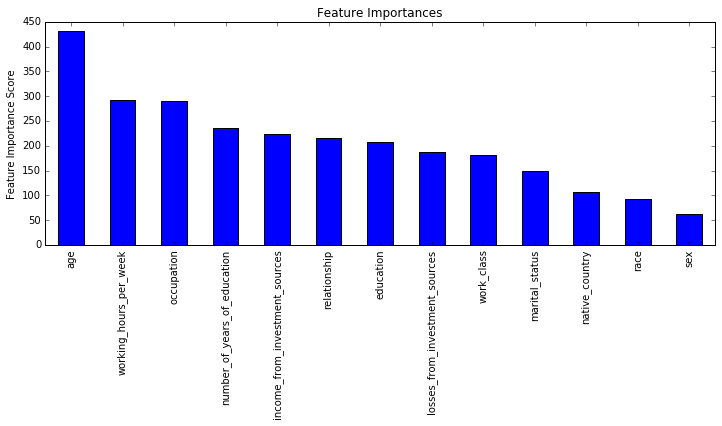

In [15]:
xgb0 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 1000,
        max_depth        = 5,
        min_child_weight = 1,
        gamma            = 0,
        subsample        = 0.8,
        colsample_bytree = 0.8,
        reg_alpha        = 0.05,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
        seed             = 27)
train_pred, test_pred = modelfit(xgb0, train, test, predictors, target)


Will train until cv error hasn't decreased in 50 rounds.



Model Report
Accuracy (CV) : 0.850119047619
Accuracy (Test) : 0.8624
AUC Score (Test): 0.916363


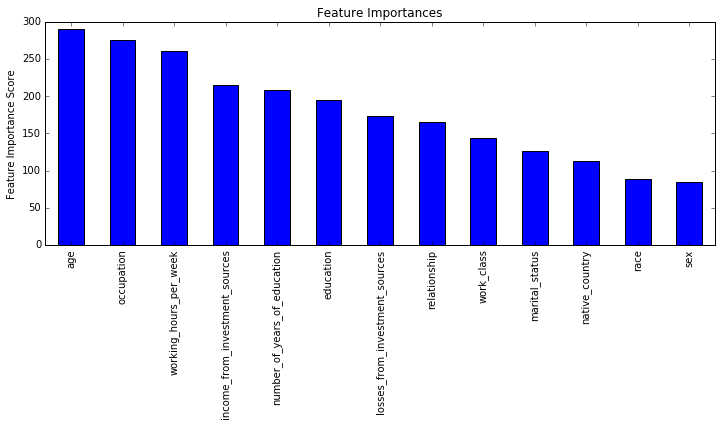

In [18]:
xgb1 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 120,
        max_depth        = 5,
        min_child_weight = 1,
        gamma            = 0.4,
        subsample        = 0.85,
        colsample_bytree = 0.5,
        reg_alpha        = 0.05,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
        seed             = 27)
train_pred, test_pred = modelfit(xgb1, train, test, predictors, target)


Model Report
Accuracy : 0.8762
AUC Score (Train): 0.936278


Will train until cv error hasn't decreased in 50 rounds.


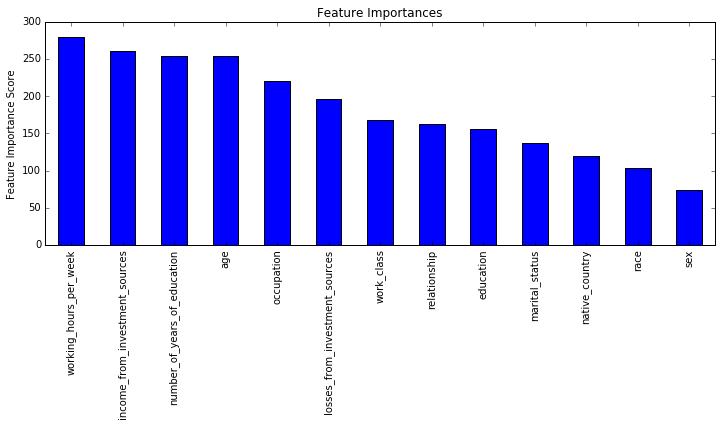

In [22]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train_pred, test_pred = modelfit(xgb1, train, test, predictors, target)

In [23]:
test_pred[[target,'Prediction']].describe
test_pred.to_csv('../data/tune_1', columns=['Id','Prediction'], \
                 index = False)

### numerical data with fill

/home/jihong/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/jihong/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/jihong/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view 


Model Report
Accuracy (CV) : 0.855047619048


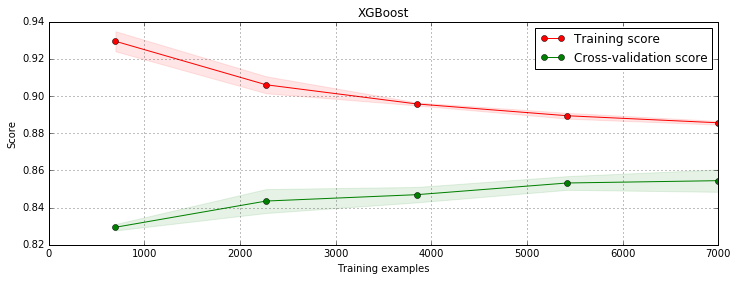

In [71]:
# read data
dftrain = pd.read_csv('../data/train.csv')
dftest = pd.read_csv('../data/test.csv')

# specify index, predictors and target
index  = 'Id'
target = 'earn_over_4k_euros_per_year'
predictors = [x for x in dftrain.columns if x not in [target,index]]

# shuffle data (IMPORTANT 88% yo 83%)
dftrain = dftrain.reindex(np.random.permutation(dftrain.index))

# fill missing values
# none
dftrain_ffill = deepcopy(dftrain)
dftest_ffill  = deepcopy(dftest)
# ffill
# dftrain_ffill = dftrain.fillna(method='ffill')
# dftest_ffill  = dftest.fillna(method='ffill')
# dftrain_ffill = dftrain_ffill.fillna(method='bfill')
# dftest_ffill = dftest_ffill.fillna(method='bfill')
# mode
df = pd.concat([dftrain,dftest], ignore_index=True)
dftrain_ffill = dftrain.fillna(value=df.mode().iloc[0])
dftest_ffill  = dftest.fillna(value=df.mode().iloc[0])

# split dftrain
train, test = train_test_split(dftrain_ffill, test_size=0.2, random_state=103)
# construct model
xgb1 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 140,
        max_depth        = 5,
        min_child_weight = 1,
        gamma            = 0.,
        subsample        = 0.75,
        colsample_bytree = 0.6,
        reg_alpha        = 0.05,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
        seed             = 27)
xgb2 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 160,
        max_depth        = 6,
        min_child_weight = 1,
        gamma            = 0.3,
        subsample        = 0.8,
        colsample_bytree = 0.5,
        reg_alpha        = 1,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
        seed             = 27)
# evaluate
# train_pred, test_pred = modelfit(xgb1, train, test, predictors, target, useTrainCV=False)

# predict
dftrain_pred, dftest_pred = modelfit(xgb1, dftrain_ffill, dftest_ffill, predictors, target, useTrainCV=False, evaluate=False)

### binary data with ffill

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 169



Model Report
Accuracy (CV) : 0.855124556616


Will train until cv error hasn't decreased in 50 rounds.



Model Report
Accuracy (CV) : 0.870380952381


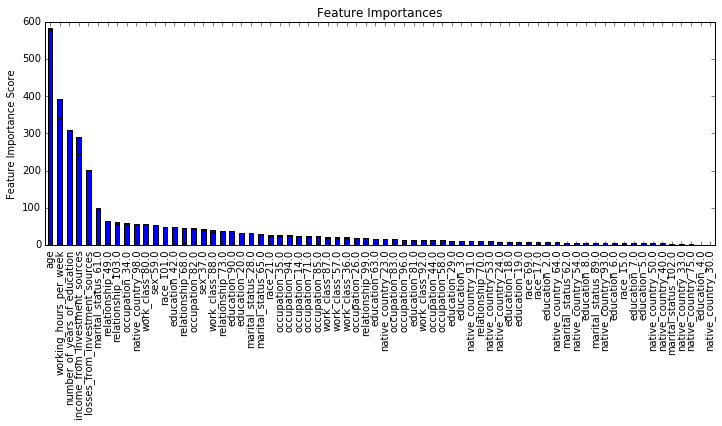

In [10]:
# read data
dftrain = pd.read_csv('../data/train.dum.csv')
dftest = pd.read_csv('../data/test.dum.csv')

# specify index, predictors and target
index  = 'Id'
target = 'earn_over_4k_euros_per_year'
predictors = [x for x in dftrain.columns if x not in [target,index]]

# fill missing values
dftrain_ffill = dftrain.fillna(method='ffill')
dftest_ffill  = dftest.fillna(method='ffill')

# split dftrain
train, test = train_test_split(dftrain, test_size=0.2, random_state=5)

# evaluate
train_pred, test_pred = modelfit(xgb0, train, test, predictors, target)

# predict
dftrain_pred, dftest_pred = modelfit(xgb0, dftrain_ffill, dftest_ffill, predictors, target, evaluate=False)

In [35]:
test_pred.to_csv('../subm/tune_2', columns=['Id','Prediction'], \
                 index = False)

### normalized data with ffill

In [8]:
# read data
dftrain = pd.read_csv('../data/train.norm.csv')
dftest = pd.read_csv('../data/test.norm.csv')

# specify index, predictors and target
index  = 'Id'
target = 'earn_over_4k_euros_per_year'
predictors = [x for x in dftrain.columns if x not in [target,index]]

# fill missing values
# keep
dftrain_ffill = deepcopy(dftrain)
dftest_ffill  = deepcopy(dftest)
# ffill
# dftrain_ffill = dftrain.fillna(method='ffill')
# dftest_ffill  = dftest.fillna(method='ffill')
# dftrain_ffill = dftrain_ffill.fillna(method='bfill')
# dftest_ffill = dftest_ffill.fillna(method='bfill')
# mode
# df = pd.concat([dftrain,dftest], ignore_index=True)
# dftrain_ffill = dftrain.fillna(value=df.mode().iloc[0])
# dftest_ffill  = dftest.fillna(value=df.mode().iloc[0])

# split dftrain
train, test = train_test_split(dftrain_ffill, test_size=0.2, random_state=103)
# construct model
xgb1 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 140,
        max_depth        = 5,
        min_child_weight = 1,
        gamma            = 0.,
        subsample        = 0.75,
        colsample_bytree = 0.6,
        reg_alpha        = 0.05,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
        seed             = 27)
xgb2 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 160,
        max_depth        = 6,
        min_child_weight = 1,
        gamma            = 0.3,
        subsample        = 0.8,
        colsample_bytree = 0.5,
        reg_alpha        = 0.05,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
        seed             = 27)
# evaluate
train_pred, test_pred = modelfit(xgb2, train, test, predictors, target, useTrainCV=False)

# predict
dftrain_pred, dftest_pred = modelfit(xgb2, dftrain_ffill, dftest_ffill, predictors, target, useTrainCV=False, evaluate=False)


Model Report
Accuracy (CV) : 0.851666666667

Model Report
Accuracy (CV) : 0.853428571429


### MCAR Data

In [8]:
# read data
dftrain = pd.read_csv('../data/train.csv')
dftest = pd.read_csv('../data/test.csv')

# specify index, predictors and target
index  = 'Id'
target = 'earn_over_4k_euros_per_year'
predictors = [x for x in dftrain.columns if x not in [target,index]]

# fill missing values
# keep

dfcomplete = pd.concat([dftrain, dftest], ignore_index=True)
dfcomplete = pd.get_dummies(dfcomplete, dummy_na=True)

dftrain_ffill = dfcomplete[dfcomplete[target]!=-1]
dftest_ffill  = dfcomplete[dfcomplete[target]==-1]



# split dftrain
train, test = train_test_split(dftrain_ffill, test_size=0.2, random_state=103)
# construct model
xgb1 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 140,
        max_depth        = 5,
        min_child_weight = 1,
        gamma            = 0.,
        subsample        = 0.75,
        colsample_bytree = 0.6,
        reg_alpha        = 0.05,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
        seed             = 27)
xgb2 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 160,
        max_depth        = 6,
        min_child_weight = 1,
        gamma            = 0.3,
        subsample        = 0.8,
        colsample_bytree = 0.5,
        reg_alpha        = 0.05,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
        seed             = 27)
# evaluate
train_pred, test_pred = modelfit(xgb2, train, test, predictors, target, useTrainCV=True)

# predict
dftrain_pred, dftest_pred = modelfit(xgb2, dftrain_ffill, dftest_ffill, predictors, target, useTrainCV=True, evaluate=False)

Will train until cv error hasn't decreased in 100 rounds.



Model Report
Accuracy (CV) : 0.852261904762


Will train until cv error hasn't decreased in 100 rounds.



Model Report
Accuracy (CV) : 0.856095238095


In [22]:
dftest_pred.to_csv('../subm/entry_6', columns=['Id','Prediction'], \
                 index = False)

### Transductive xgb

In [551]:
# read data
dftrain = pd.read_csv('../data/train.dum.csv')
dftest = pd.read_csv('../data/test.dum.csv')

# specify index, predictors and target
index  = 'Id'
target = 'earn_over_4k_euros_per_year'
predictors = [x for x in dftrain.columns if x not in [target,index]]

# shuffle data (IMPORTANT 88% yo 83%)
dftrain = dftrain.reindex(np.random.permutation(dftrain.index))

# fill missing values
# none
dftrain_ffill = deepcopy(dftrain)
dftest_ffill  = deepcopy(dftest)
# ffill
# dftrain_ffill = dftrain.fillna(method='ffill')
# dftest_ffill  = dftest.fillna(method='ffill')
# dftrain_ffill = dftrain_ffill.fillna(method='bfill')
# dftest_ffill = dftest_ffill.fillna(method='bfill')
# mode
# df = pd.concat([dftrain,dftest], ignore_index=True)
# dftrain_ffill = dftrain.fillna(value=df.mode().iloc[0])
# dftest_ffill  = dftest.fillna(value=df.mode().iloc[0])

# split dftrain
train, test = train_test_split(dftrain_ffill, test_size=0.75)
# construct model
xgb1 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 140,
        max_depth        = 5,
        min_child_weight = 1,
        gamma            = 0.,
        subsample        = 0.75,
        colsample_bytree = 0.6,
        reg_alpha        = 0.05,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
        seed             = 27)
xgb2 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 160,
        max_depth        = 6,
        min_child_weight = 1,
        gamma            = 0.3,
        subsample        = 0.8,
        colsample_bytree = 0.5,
        reg_alpha        = 0.05,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
#         seed             = 27
)
# evaluate
train_pred, test_pred = modelfit(xgb2, train, test, predictors, target, \
                                 useTrainCV=True, evaluate=True, \
                                 transductive=True, max_iterations=20
                                )

# predict
# dftrain_pred, dftest_pred = modelfit(xgb2, dftrain_ffill, dftest_ffill, predictors, target, \
#                                      useTrainCV=True, evaluate=False, \
#                                      transductive=True, max_iterations=10,
#                                     )

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 65



Model Report
Accuracy (CV) : 0.839966458478
Accuracy (Test) : 0.8443
AUC Score (Test): 0.890571


In [226]:
test_pred.loc[test_pred['predprob']>0.5]

,Id,age,income_from_investment_sources,losses_from_investment_sources,number_of_years_of_education,working_hours_per_week,earn_over_4k_euros_per_year,education_2.0,education_3.0,education_4.0,...,work_class_36.0,work_class_57.0,work_class_66.0,work_class_80.0,work_class_87.0,work_class_88.0,work_class_92.0,work_class_104.0,Prediction,predprob
8188,8189,16.8700,1396.1,0.00,3.1831,12.7320,1,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.814700
5619,5620,19.0990,0.0,0.00,3.1831,12.7320,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.654275
9804,9805,14.6420,0.0,0.00,4.1380,14.3240,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.761460
4015,4016,13.3690,0.0,636.94,4.4563,19.0990,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.593161
9533,9534,14.6420,0.0,0.00,2.8648,22.2820,1,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.525048
7386,7387,11.7770,0.0,0.00,3.5014,9.5493,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.545305
9522,9523,11.4590,0.0,0.00,4.4563,12.7320,1,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.829768
8887,8888,21.6450,0.0,0.00,5.0930,19.0990,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.830037
9642,9643,18.7800,0.0,605.43,2.8648,16.5520,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.940861
10445,10446,11.7770,0.0,0.00,3.5014,14.3240,1,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.650120


In [174]:
dftest_pred[predictors]

,age,income_from_investment_sources,losses_from_investment_sources,number_of_years_of_education,working_hours_per_week,education_2.0,education_3.0,education_4.0,education_5.0,education_6.0,...,sex_37.0,sex_59.0,work_class_36.0,work_class_57.0,work_class_66.0,work_class_80.0,work_class_87.0,work_class_88.0,work_class_92.0,work_class_104.0
0,7.6394,0.0,0.00,3.18310,5.7296,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,16.2340,0.0,777.95,3.50140,12.4140,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,19.7350,0.0,0.00,2.86480,12.7320,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,6.3662,0.0,0.00,3.18310,3.8197,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,13.3690,0.0,0.00,3.50140,10.1860,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,11.7770,0.0,0.00,1.27320,15.9150,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,10.5040,0.0,0.00,2.22820,12.7320,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,15.9150,0.0,0.00,3.18310,12.7320,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,11.4590,0.0,0.00,4.13800,17.5070,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,13.3690,0.0,0.00,2.86480,12.7320,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [89]:
dftrain_ffill.shape, dftest_ffill.shape

((10500, 15), (38342, 15))

In [529]:
dftest_pred[[index,'Prediction']]

,Id,Prediction
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [530]:
dftest_pred.to_csv('../subm/entry_5', columns=['Id','Prediction'], \
                 index = False)